In [161]:
# This cell includes the major classes used in our classification analyses
import matplotlib.pyplot as plt # needed for plotting
import numpy as np # numpy is primary library for numeric array (and matrix) handling
from scipy import signal 

# Each accelerometer and gyroscope log file gets parsed and made into a SensorData object
class SensorData:
    
    # Constructors in Python look like this (strangely enough)
    # All arguments are numpy arrays except sensorType, which is a str
    def __init__(self, sensorType, currentTimeMs, sensorTimestampNano, x, y, z):
        self.sensorType = sensorType
        
        # On my mac, I could cast as straight-up int but on Windows, this failed
        # This is because on Windows, a long is 32 bit but on Unix, a long is 64bit
        # So, forcing to int64 to be safe. See: https://stackoverflow.com/q/38314118
        self.currentTimeMs = currentTimeMs.astype(np.int64)
        self.sensorTimestampNano = sensorTimestampNano.astype(np.int64)
        
        self.x = x.astype(float)
        self.y = y.astype(float)
        self.z = z.astype(float)
   
        xSquared = np.multiply(self.x , self.x)
        ySquared = np.multiply(self.y, self.y)
        zSquared = np.multiply(self.z, self.z)
        self.mag = np.sqrt(np.add(xSquared, ySquared, zSquared))
        
    # Returns a dict of numpy arrays
    def get_data(self):
        return {"x":self.x, "y":self.y, "z":self.z, "mag":self.mag}
    
    # Pads the end of each data array with zeroes. Throws exception
    # if newArrayLength smaller than the current data array (and thus nothing to pad)
    def pad_with_zeros(self, newArrayLength):
        arrayLengthDiff = newArrayLength - len(self.x)
        if arrayLengthDiff < 0:
            raise ValueError("New array length '{}' must be larger than current array length '{}".
                             format(newArrayLength, len(self.x)))
        
        # np.pad allows us to pad either the left side, right side, or both sides of an array
        # in this case, we are padding only the right side. See: https://docs.scipy.org/doc/numpy/reference/generated/numpy.pad.html
        self.x = np.pad(self.x, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.y = np.pad(self.y, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.z = np.pad(self.z, (0, arrayLengthDiff), 'constant', constant_values=0)
        self.mag = np.pad(self.mag, (0, arrayLengthDiff), 'constant', constant_values=0)

# A trial is one gesture recording and includes an accel SensorData object and a gyro SensorData object
class Trial:
    
    # We actually parse the sensor log files in the constructor--this is probably bad practice
    # But offers a relatively clean solution
    def __init__(self, gestureName, endTimeMs, trialNum, accelLogFilenameWithPath, gyroLogFilenameWithPath):
        self.gestureName = gestureName
        self.trialNum = trialNum
        self.endTimeMs = endTimeMs
        self.accelLogFilenameWithPath = accelLogFilenameWithPath
        self.gyroLogFilenameWithPath = gyroLogFilenameWithPath
        
        # unpack=True puts each column in its own array, see https://stackoverflow.com/a/20245874
        # I had to force all types to strings because auto-type inferencing failed
        parsedAccelLogData = np.genfromtxt(accelLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        # The asterisk is really cool in Python. It allows us to "unpack" this variable
        # into arguments needed for the SensorData constructor. Google for "tuple unpacking"
        self.accel = SensorData("Accelerometer", *parsedAccelLogData[1:])
        
        parsedGyroLogData = np.genfromtxt(gyroLogFilenameWithPath, delimiter=',', 
                              dtype=str, encoding=None, skip_header=1, unpack=True)
        
        self.gyro = SensorData("Accelerometer", *parsedGyroLogData[1:])
    
    # Utility function that returns the end time as a nice string
    def getEndTimeMsAsString(self):
        return time.strftime('%Y-%m-%d %H:%M:%S', time.localtime(self.endTimeMs / 1000))
    
class KFoldCrossValidation:
    def __init__(self , transformedSignalFolds):
        self.transformedFolds = transformedSignalFolds
    def runCrossValidation(self):
        return
    
class SignalTransformer(object):
    @staticmethod
    def smoothAndDetrendSignal(inputsignal):
        smoothingWindowSize = 10 
        inputsignal.accel.mag = np.convolve(
            inputsignal.accel.mag, np.ones((smoothingWindowSize,))/smoothingWindowSize, mode='valid')
        # inputsignal.accel.mag = signal.detrend(inputsignal.accel.mag)
        inputsignal.accel.x = np.convolve(
            inputsignal.accel.x, np.ones((smoothingWindowSize,))/smoothingWindowSize, mode='valid')
        # inputsignal.accel.x = signal.detrend(inputsignal.accel.x)
        inputsignal.accel.y = np.convolve(
            inputsignal.accel.y, np.ones((smoothingWindowSize,))/smoothingWindowSize, mode='valid')
        # inputsignal.accel.y = signal.detrend(inputsignal.accel.y)
        inputsignal.accel.z = np.convolve(
            inputsignal.accel.z, np.ones((smoothingWindowSize,))/smoothingWindowSize, mode='valid')
        # inputsignal.accel.z = signal.detrend(inputsignal.accel.z)
        
        return inputsignal

In [162]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [163]:
# This cell contains our file handling and parsing related functions
from os import listdir
import ntpath
import os

# Returns all csv filenames in the given directory
def find_csv_filenames( path_to_dir, suffix=".csv" ):
    filenames = listdir(path_to_dir)
    return [ filename for filename in filenames if filename.endswith( suffix ) ]

# Parses and creates Trial objects for all csv files in the given dir
# Returns a dict() mapping (str: gestureName) to (list: Trial objects)
def parse_and_create_gesture_trials( path_to_dir ):
    csvFilenames = find_csv_filenames(path_to_dir)
    
    print("Found {} csv files in {}".format(len(csvFilenames), path_to_dir))
    
    mapGestureNameToTrialList = dict()
    mapGestureNameToMapEndTimeMsToMapSensorToFile = dict()
    for csvFilename in csvFilenames:
        # parse filename into meaningful parts
        filenameNoExt = os.path.splitext(csvFilename)[0];
        filenameParts = filenameNoExt.split("_")
        gestureName = filenameParts[0]
        sensorName = filenameParts[1]
        timeMs = int(filenameParts[2])
        
        # print("gestureName={} sensorName={} timeMs={}".format(gestureName, sensorName, timeMs))
        
        if gestureName not in mapGestureNameToMapEndTimeMsToMapSensorToFile:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName] = dict()
        
        if timeMs not in mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName]:
            mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs] = dict()
        
        mapGestureNameToMapEndTimeMsToMapSensorToFile[gestureName][timeMs][sensorName] = csvFilename
        # print (mapGestureNameToMapEndTimeMsToMapSensorToFile)
    
    print("Found {} gestures".format(len(mapGestureNameToMapEndTimeMsToMapSensorToFile)))
    
    # track the longest array so we can resize accordingly (by padding with zeros currently)
    maxArrayLength = -1
    trialWithMostSensorEvents = None
    
    # Now we need to loop through the data and sort each gesture set by timems values 
    # (so that we have trial 1, 2, 3, etc.)
    for gestureName, mapEndTimeMsToMapSensorToFile in mapGestureNameToMapEndTimeMsToMapSensorToFile.items():
        gestureTrialNum = 0
        mapGestureNameToTrialList[gestureName] = list()
        for endTimeMs in sorted(mapEndTimeMsToMapSensorToFile.keys()):
            mapSensorToFile = mapEndTimeMsToMapSensorToFile[endTimeMs]
            
            accelFilenameWithPath = os.path.join(logPath, mapSensorToFile["Accelerometer"])
            gyroFilenameWithPath = os.path.join(logPath, mapSensorToFile["Gyroscope"])
            
            gestureTrial = Trial(gestureName, endTimeMs, gestureTrialNum, accelFilenameWithPath, gyroFilenameWithPath)
            mapGestureNameToTrialList[gestureName].append(gestureTrial)
            
            if maxArrayLength < len(gestureTrial.accel.x):
                maxArrayLength = len(gestureTrial.accel.x)
                trialWithMostSensorEvents = gestureTrial
            
            gestureTrialNum = gestureTrialNum + 1
        
        print("Found {} trials for '{}'".format(len(mapGestureNameToTrialList[gestureName]), gestureName))
    
    # Some basic preprocessing
    # Resize arrays so everything is same length (necessary for shape matching) 
    print("Max trial length across all gesture is '{}' Trial {} with {} sensor events. Resizing all arrays to match".
          format(trialWithMostSensorEvents.gestureName, trialWithMostSensorEvents.trialNum, maxArrayLength))
    for gestureName, trialList in mapGestureNameToTrialList.items():
        for trial in trialList: 
            trial.accel.pad_with_zeros(maxArrayLength)
            trial.gyro.pad_with_zeros(maxArrayLength)
          
    return mapGestureNameToTrialList
        
# Returns the leafs in a path
# From: https://stackoverflow.com/a/8384788
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail or ntpath.basename(head)

# Utility function to extract gesture name from filename
def extract_gesture_name( filename ):
    # leaf = path_leaf(filename)
    tokenSplitPos = filename.index('_')
    gestureName = filename[:tokenSplitPos]
    return gestureName

# Returns the minimum number of trials across all gestures (just in case we accidentally recorded a 
# different number. We should have 5 or 10 each for the A2 assignment)
def get_min_num_of_trials( mapGestureToTrials ):
    minNumTrials = -1 
    for gestureName, trialSet in mapGestureToTrials.items():
        if minNumTrials == -1 or minNumTrials > len(trialSet):
            minNumTrials = len(trialSet)
    return minNumTrials

In [164]:
logPath ="D:\JonGestureLogs"
from scipy.spatial import distance

mapGestureToTrials = parse_and_create_gesture_trials(logPath)

Found 100 csv files in D:\JonGestureLogs
Found 10 gestures
Found 5 trials for 'At Rest'
Found 5 trials for 'Backhand Tennis'
Found 5 trials for 'Baseball Throw'
Found 5 trials for 'Forehand Tennis'
Found 5 trials for 'Midair Clockwise O'
Found 5 trials for 'Midair Counter Clockwise O'
Found 5 trials for 'Midair S'
Found 5 trials for 'Midair Zorro Z'
Found 5 trials for 'Shake'
Found 5 trials for 'Underhand Bowling'
Max trial length across all gesture is 'At Rest' Trial 3 with 323 sensor events. Resizing all arrays to match


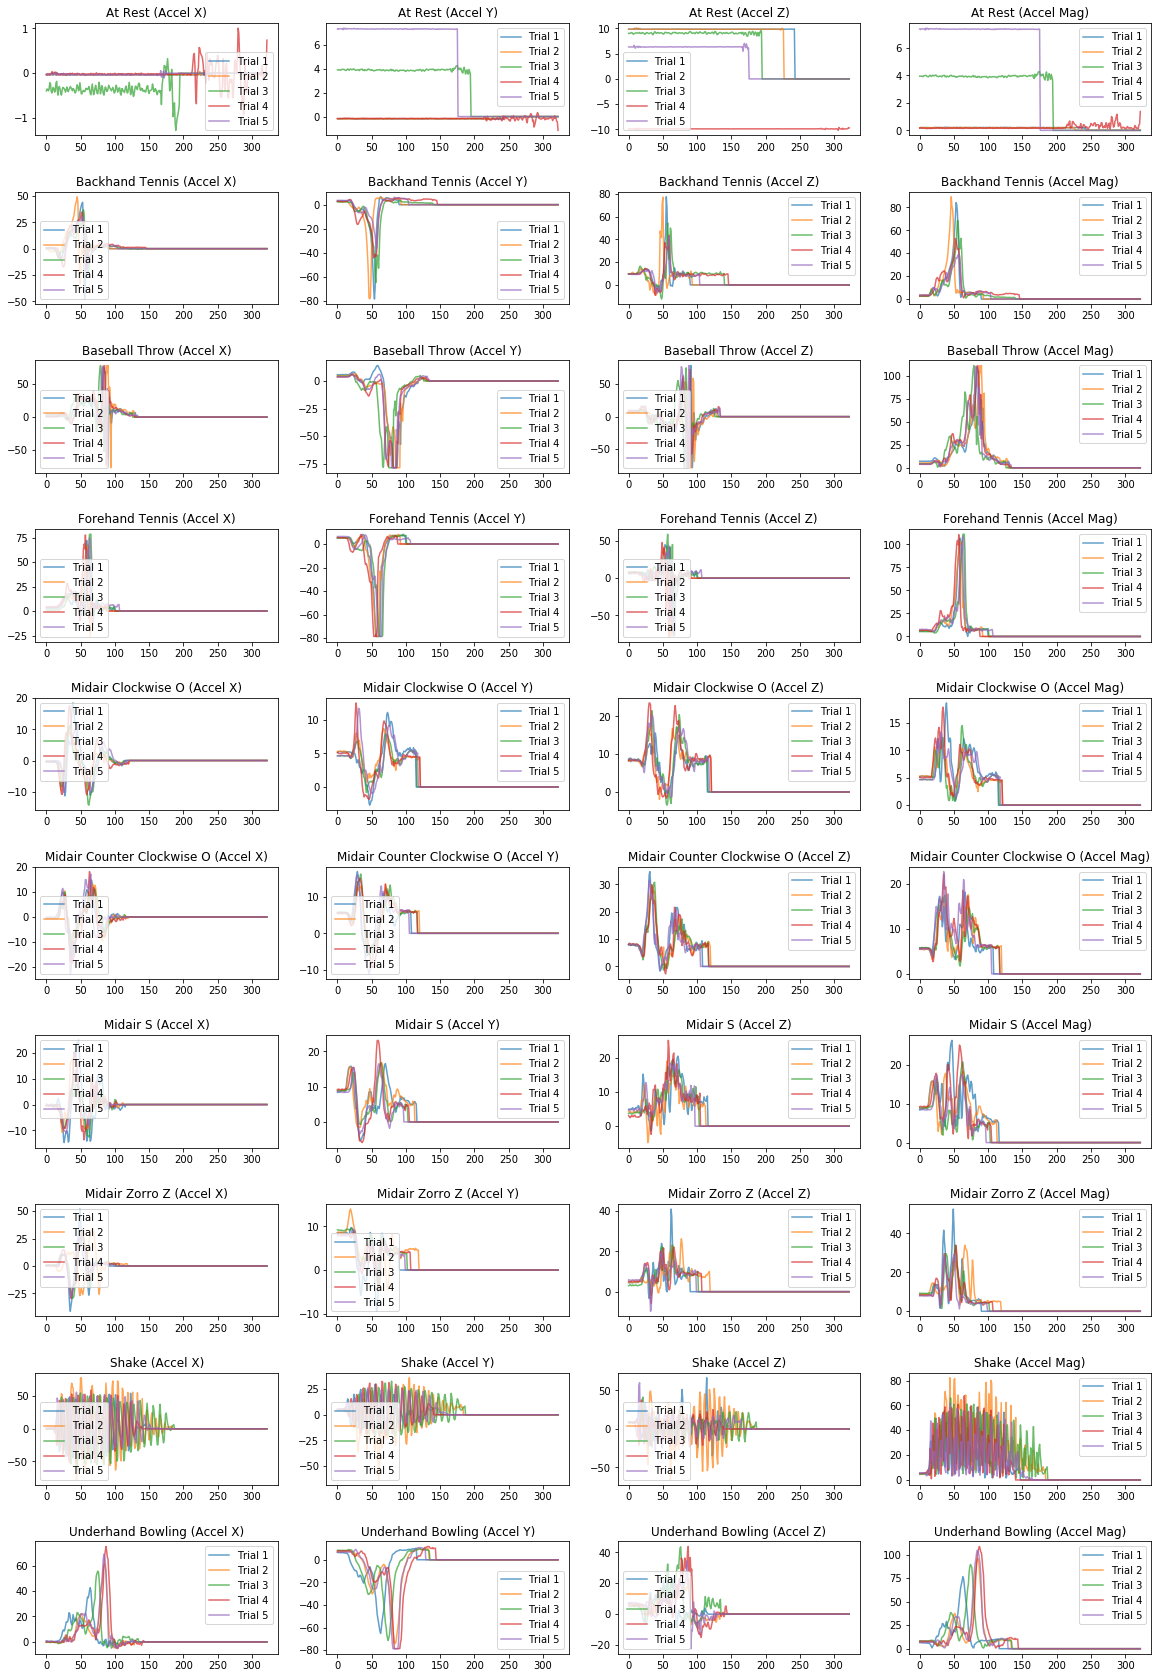

In [165]:
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1

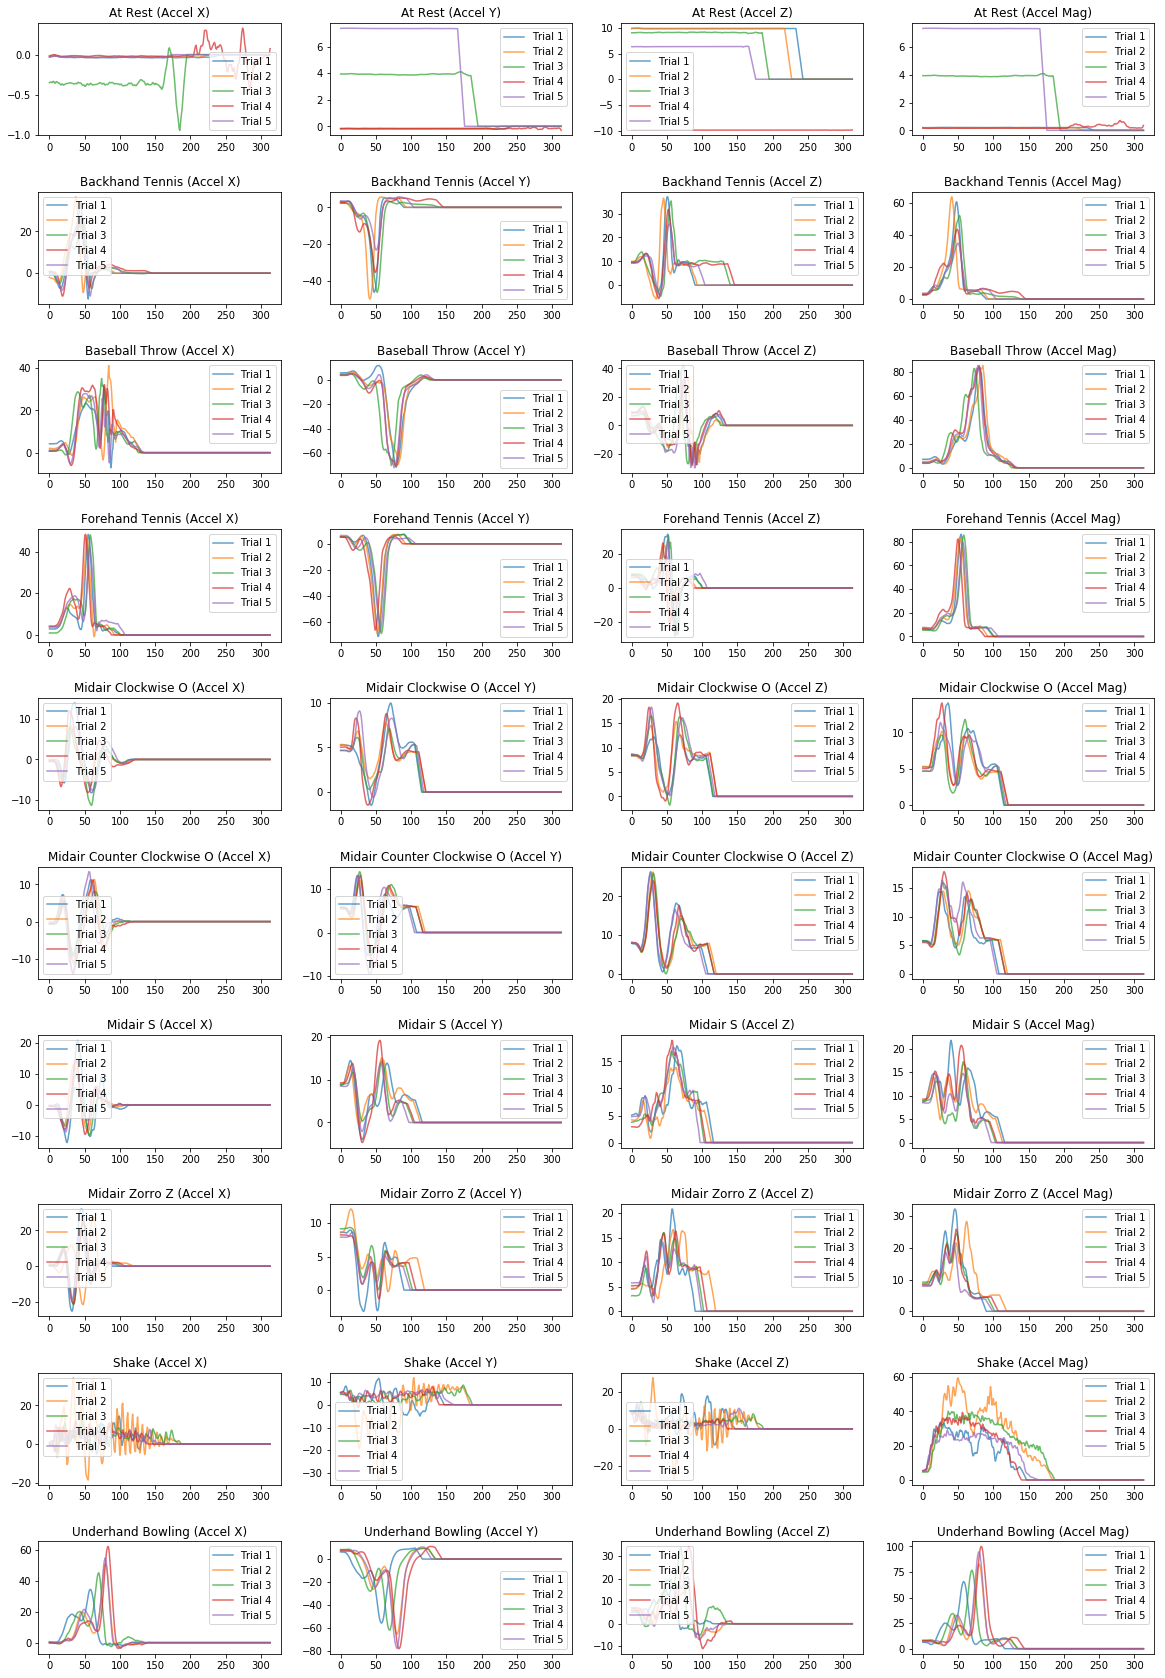

In [166]:
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

index = 0
gestureNamesSorted = sorted(mapGestureToTrials.keys())
for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    
    trialNum = 1
    for trial in gestureTrials:
        SignalTransformer.smoothAndDetrendSignal(trial)
        axes[index][0].plot(trial.accel.x, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][1].plot(trial.accel.y, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][2].plot(trial.accel.z, alpha=0.7, label="Trial {}".format(trialNum))
        axes[index][3].plot(trial.accel.mag, alpha=0.7, label="Trial {}".format(trialNum))
        trialNum = trialNum + 1
        
    axes[index][0].set_title(gestureName + " (Accel X)")
    axes[index][0].legend()
    
    axes[index][1].set_title(gestureName + " (Accel Y)")
    axes[index][1].legend()
    
    axes[index][2].set_title(gestureName + " (Accel Z)")
    axes[index][2].legend()
    
    axes[index][3].set_title(gestureName + " (Accel Mag)")
    axes[index][3].legend()
    index = index + 1

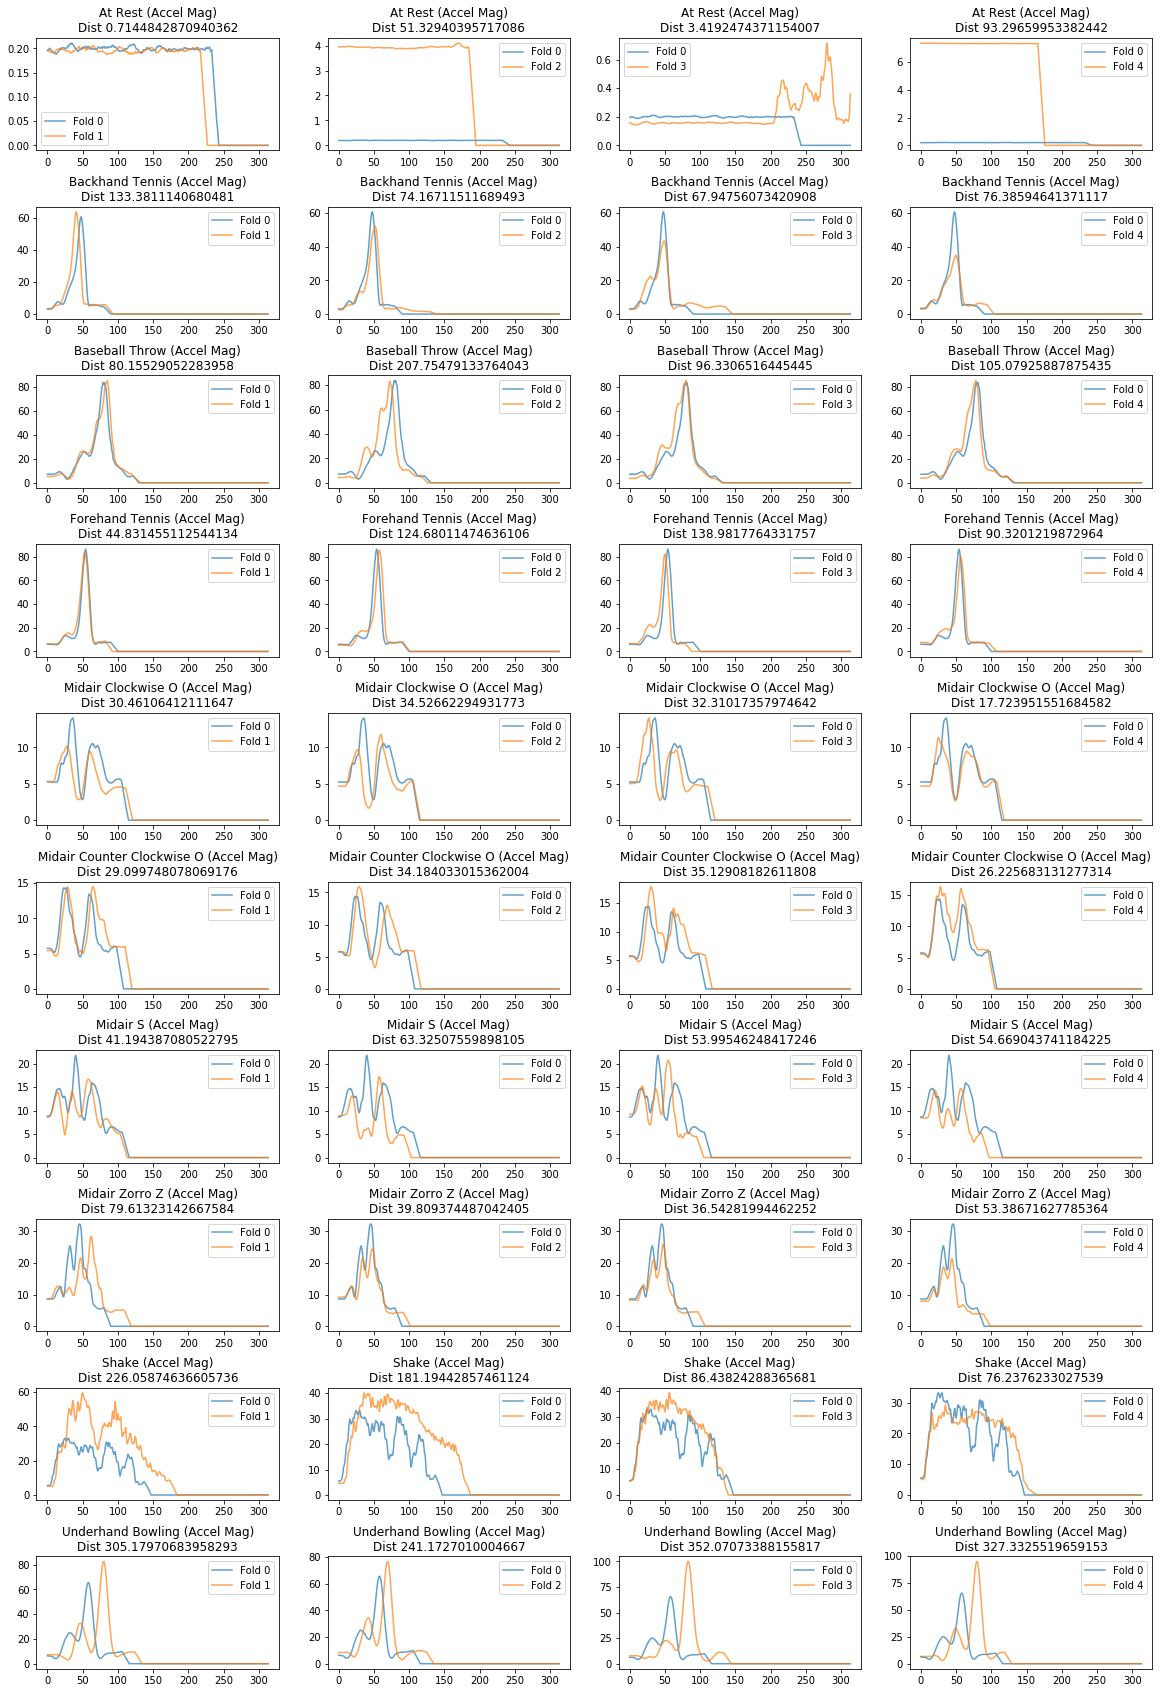

In [167]:
fig, axes = plt.subplots(len(mapGestureToTrials), 4, figsize=(20, 3 * len(mapGestureToTrials)))
fig.subplots_adjust(hspace=0.5)

from scipy.spatial import distance

# Construct the folds for cross validation. For this experiment we will
# use a fold of 5 . Every fold contains a trial of a gesture.
gestureFolds =  [[] for i in range(5)]
gestureNamesSorted = sorted(mapGestureToTrials.keys())

for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    trialNum = 1
    for trial in gestureTrials:
        gestureFolds[trialNum-1].append(trial)    
        trialNum = trialNum + 1

axesindex = 0
plotindex = 0
for i in range(len(gestureFolds)):
    for j in range(len(gestureFolds[i])):
        plotindex = 0
        for p in range(len(gestureFolds)):
            for q in range(len(gestureFolds[p])):
                if j == q and i != p:
                    if i == 0:
                        euclideanDist = distance.euclidean(gestureFolds[i][j].accel.mag,gestureFolds[p][q].accel.mag)
                        axes[axesindex][plotindex].plot(gestureFolds[i][j].accel.mag ,alpha=0.7, label="Fold {0}".format(i)) 
                        axes[axesindex][plotindex].plot(gestureFolds[p][q].accel.mag, alpha=0.7, label="Fold {0}".format(p)) 
                        axes[axesindex][plotindex].set_title(
                            gestureFolds[i][j].gestureName + " (Accel Mag)\nDist {}".format(euclideanDist))
                        axes[axesindex][plotindex].legend()
                        plotindex = plotindex + 1
        if(i==0):
            axesindex = axesindex+1;

In [168]:
from scipy.spatial import distance

# Construct the folds for cross validation. For this experiment we will
# use a fold of 5 . Every fold contains a trial of a gesture.
gestureFolds =  [[] for i in range(5)]
gestureNamesSorted = sorted(mapGestureToTrials.keys())
predictionCountByGesture = dict()

for gestureName in gestureNamesSorted:
    gestureTrials = mapGestureToTrials[gestureName]
    trialNum = 1
    for trial in gestureTrials:
        gestureFolds[trialNum-1].append(trial)    
        trialNum = trialNum + 1
        
gesturePrediction = [[[] for i in range(len(gestureNamesSorted))] for i in range(len(gestureFolds))]

#some big number to seed the algorithm
minEuclidianDistance = 999999999999999999999999
for i in range(len(gestureFolds)):
    for j in range(len(gestureFolds[i])):
        plotindex = 0
        # reset for next ieration.
        minEuclidianDistance = 999999999999999999999999
        for p in range(len(gestureFolds)):
            for q in range(len(gestureFolds[p])):
                if i != p:
                    correlateAToB = signal.correlate(gestureFolds[i][j].accel.mag,gestureFolds[p][q].accel.mag)
                    bestCorrelationPoint = np.argmax(correlateAToB)
                    indexShift = bestCorrelationPoint
                    gestureFolds[p][q].accel.mag = np.roll(gestureFolds[p][q].accel.mag, indexShift)
                    euclideanDist = distance.euclidean(gestureFolds[i][j].accel.mag,gestureFolds[p][q].accel.mag)
                    if euclideanDist<minEuclidianDistance:
                        minEuclidianDistance = euclideanDist
                        gesturePrediction[i][j]= gestureFolds[p][q]
        if gesturePrediction[i][j].gestureName == gestureFolds[i][j].gestureName:
            if gestureFolds[i][j].gestureName in predictionCountByGesture:
                predictionCountByGesture[gestureFolds[i][j].gestureName] = predictionCountByGesture[
                    gestureFolds[i][j].gestureName] + 1
            else:
                predictionCountByGesture[gestureFolds[i][j].gestureName] = 1

In [174]:
# Print percentage success for predictions.
foldLength = len(gestureFolds)
totalSuccessfulPrediction = 0
for key,value in predictionCountByGesture.items():
    totalSuccessfulPrediction = totalSuccessfulPrediction + value
    print ("{0}-{1}/{2}-({3}%)".format(key,value,foldLength,((value/foldLength)*100)))
print ("Total Prediction Accuracy {0}%".format(
    totalSuccessfulPrediction/(foldLength*len(predictionCountByGesture))*100))

At Rest-4/5-(80.0%)
Backhand Tennis-4/5-(80.0%)
Baseball Throw-5/5-(100.0%)
Forehand Tennis-5/5-(100.0%)
Midair Clockwise O-5/5-(100.0%)
Midair Counter Clockwise O-5/5-(100.0%)
Midair S-4/5-(80.0%)
Midair Zorro Z-5/5-(100.0%)
Shake-5/5-(100.0%)
Underhand Bowling-5/5-(100.0%)
Total Prediction Accuracy 94.0%


Confusion matrix, without normalization
[[4 0 0 0 1 0 0 0 0 0]
 [0 4 0 0 0 0 0 1 0 0]
 [0 0 5 0 0 0 0 0 0 0]
 [0 0 0 5 0 0 0 0 0 0]
 [0 0 0 0 5 0 0 0 0 0]
 [0 0 0 0 0 5 0 0 0 0]
 [0 0 0 0 0 1 4 0 0 0]
 [0 0 0 0 0 0 0 5 0 0]
 [0 0 0 0 0 0 0 0 5 0]
 [0 0 0 0 0 0 0 0 0 5]]
Normalized confusion matrix
[[0.8 0.  0.  0.  0.2 0.  0.  0.  0.  0. ]
 [0.  0.8 0.  0.  0.  0.  0.  0.2 0.  0. ]
 [0.  0.  1.  0.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  1.  0.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  1.  0.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  1.  0.  0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.2 0.8 0.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  1.  0.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  1.  0. ]
 [0.  0.  0.  0.  0.  0.  0.  0.  0.  1. ]]


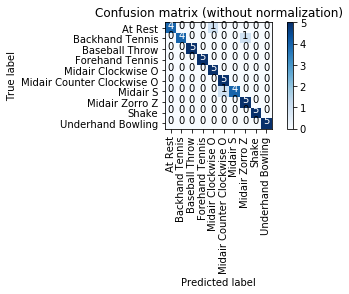

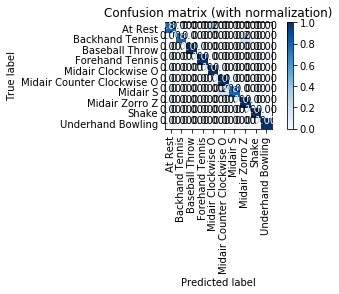

In [170]:
y_true = []
y_pred = []
labels = []

for i in range(len(gestureFolds)):
    for j in range(len(gestureFolds[i])):
        y_true.append(gestureFolds[i][j].gestureName)
        if i== 0:
            labels.append(gestureFolds[i][j].gestureName)

for i in range(len(gesturePrediction)):
    for j in range(len(gesturePrediction[i])):
        y_pred.append(gesturePrediction[i][j].gestureName)
        
cm = confusion_matrix(y_true, y_pred, labels)
plt.figure()
plot_confusion_matrix(cm, classes=labels,
                      title='Confusion matrix (without normalization)')

plt.figure()
plot_confusion_matrix(cm, classes=labels, normalize=True,
                      title='Confusion matrix (with normalization)')
plt.show()